In [6]:
%matplotlib inline
import pandas as pd, datetime as dt
import collections
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import glob, os

### Input CO2 T-A and fuel type

In [15]:
TA = 159  # g/km, the type-approval for this vehicle

fuel_type = str('diesel')

In [8]:
if fuel_type == 'diesel':
    NOx_lim = 80 # mg/km
elif fuel_type == 'gasoline':
    NOx_lim = 60 # mg/km
else:
    show('continue')
    
print(NOx_lim)

80


## PN vs CO2

In [9]:
files = glob.glob('*C.xlsx')                                     # read lab files (-7C) 

dic = {}                                                            # empty dictionary lab test

i = 1
for each in files:
  
    %time df = pd.read_excel(each, sheetname=1, header=0)                          # read the proper sheets within each file

    v = df['DACtrl_ActualSpeed\n[kph]']                                # speed 
    t_s = len(df.index)                                                # time(s)
    t_m = t_s/60                                                       # time (min)
    t_h = t_s/3600                                                     # time (h)
    v_mean = v.mean()                                                  # speed means
    d = v_mean * t_h                                                   # distance means

    CO2 = df['c_CO2_Dil_g_vec\n[grams]']
    CO2_sum = CO2.sum()
    CO2km = CO2_sum/d                                                    # CO2 per km 
    #CO2pct = CO2km*100/CO2_TA                                            # emissions as % of type approval (98 g/km)

    flow_gas = df['c_Vmix_vec\n[m3/min]']                               # flow of gas mixture [m3/min]
    flow_avg = flow_gas.sum()/t_s                                       # average in m3/min
    vol_gas = flow_avg * t_m                                            # total volume of gas mixture (m3)
    vol_gas_cc = vol_gas * 1e6                                          # total volume of gas mixture (cm3)

    PN = df["Counter\n[cpcc]"]                                         # column of PN flow in #/cm3
    PN_sum = PN.sum()                                                  
    PN_avg = PN_sum / t_s                                               # average of flow in #/cm3
    
    PN_total = PN_avg * vol_gas_cc                                      # total emitted in #
    PN_total_km = PN_total / d                                          # total emission in #/km
    
    key = each.split('dal_')[1].split('.x')[0]                             # shortening the titles of the files
    
    key = str(i) + "." + str(key)                                        # numbering the files
    dic[key] = [CO2km, vol_gas_cc, t_s, t_m, d, PN_sum, PN_avg, PN_total_km] # save means in the dictionary 
    i = i+1

Wall time: 1.12 s
Wall time: 1.09 s
Wall time: 1.07 s
Wall time: 1.08 s
Wall time: 1.08 s
Wall time: 1.09 s
Wall time: 1.05 s
Wall time: 1.05 s
Wall time: 1.07 s
Wall time: 1.05 s
Wall time: 1.06 s


In [10]:
lab = pd.DataFrame()                                                          
lab = lab.from_dict(dic, orient='index')                                       # convert dic to dataframe
lab['ind2'] = ['3','4','1','3','4','1','3','2','4','3','4']             # proper order
lab.columns = ['CO2km', 'vol_gas_cc', 't_s', 't_m', 'd', 'PN_sum', 'PN_avg', 'PN_total_km','ind2']               # headers
lab = lab.sort_values('ind2')

In [11]:
lab['test'] = ['N_CD_23','N_CD_23','N+10%_CD_23','N_HT_23','N_HT_23','N_HT_23',
               'N_HT_23','N_mod_HT_23','N_mod_HT_23','N_mod_HT_23','N_mod_HT_23']

lab.columns = ['CO2km', 'vol_gas_cc', 't_s', 't_m', 'd', 'PN_sum', 'PN_avg', 'PN_total_km','ind2','test']
lab

,CO2km,vol_gas_cc,t_s,t_m,d,PN_sum,PN_avg,PN_total_km,ind2,test
3.NEDC_COLD_4WD_23°C,144.970983,1.736608e+08,1181,19.683333,10.890319,3.656439e+06,3096.053261,4.937074e+10,1,N_CD_23
6.NEDC_COLD_4WD_23°C,144.093839,1.738966e+08,1180,19.666667,10.887156,2.913046e+05,246.868319,3.943138e+09,1,N_CD_23
8.NEDC +10%VELOC_COLD_4WD_23°C,148.804844,1.740129e+08,1180,19.666667,11.972481,1.545509e+05,130.975376,1.903649e+09,2,N+10%_CD_23
1.NEDC_HOT_4WD_23°C,131.801099,1.734726e+08,1181,19.683333,10.887590,1.271414e+05,107.655703,1.715284e+09,3,N_HT_23
4.NEDC_HOT_4WD_23°C,128.455904,1.737304e+08,1181,19.683333,10.866885,1.757486e+05,148.813420,2.379101e+09,3,N_HT_23
7.NEDC_HOT_4WD_23°C,128.670890,1.740573e+08,1181,19.683333,10.912200,1.181598e+05,100.050619,1.595878e+09,3,N_HT_23
10.NEDC_HOT_4WD_23°C,127.562589,1.738034e+08,1180,19.666667,10.885772,1.281272e+05,108.582370,1.733637e+09,3,N_HT_23
2.NEDC MODIFICATO_HOT_4WD_23°C,121.167810,1.746179e+08,1181,19.683333,12.058522,1.824824e+05,154.515165,2.237514e+09,4,N_mod_HT_23
5.NEDC MODIFICATO_HOT_4WD_23°C,117.920916,1.734732e+08,1181,19.683333,11.929958,1.286318e+05,108.917727,1.583770e+09,4,N_mod_HT_23
9.NEDC MODIFICATO_HOT_4WD_23°C,123.299401,1.740233e+08,1181,19.683333,11.943908,1.436766e+05,121.656767,1.772544e+09,4,N_mod_HT_23


In [12]:
name = lab.groupby(lab.ind2).mean()#.reset_index()#drop = True)
name['test'] = ['N_CD_23','N+10%_CD_23','N_HT_23','N_mod_HT_23']
name.columns = ['CO2km', 'vol_gas_cc', 't_s', 't_m', 'd', 'PN_sum', 'PN_avg', 'PN_total_km','test']

name

,CO2km,vol_gas_cc,t_s,t_m,d,PN_sum,PN_avg,PN_total_km,test
ind2,,,,,,,,,
1,144.532411,1.737787e+08,1180.50,19.675000,10.888737,1.973872e+06,1671.460790,2.665694e+10,N_CD_23
2,148.804844,1.740129e+08,1180.00,19.666667,11.972481,1.545509e+05,130.975376,1.903649e+09,N+10%_CD_23
3,129.122621,1.737659e+08,1180.75,19.679167,10.888112,1.372943e+05,116.275528,1.855975e+09,N_HT_23
4,120.489826,1.740370e+08,1181.00,19.683333,11.965441,1.438329e+05,121.789041,1.770710e+09,N_mod_HT_23


## Plot all tests

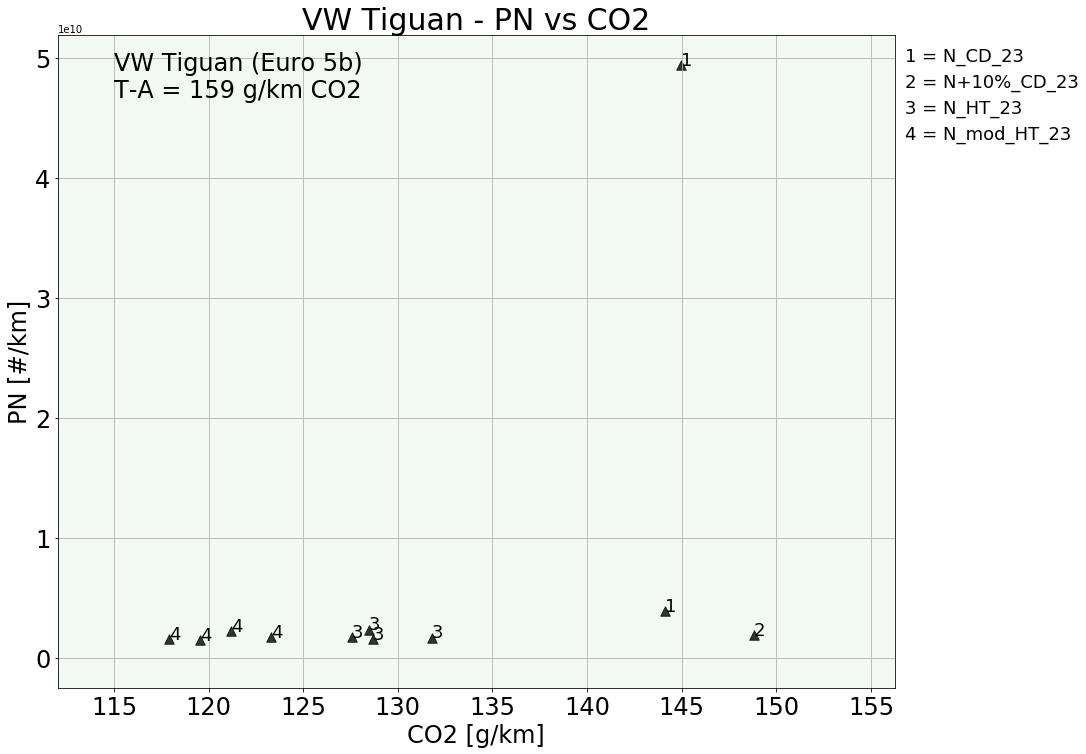

In [16]:
ax = lab.plot.scatter('CO2km', 'PN_total_km', marker="^", alpha=.8 ,s = 90, c = 'black', 
                      figsize=(15, 12), grid ='on')
#plt.set_size_inches()

#legend = ('LAB')
#plt.legend(legend, fontsize = 16, loc = 'upper right')

lim_inf_CO2 = lab.CO2km.min()-0.05*lab.CO2km.min()
lim_sup_CO2 = lab.CO2km.max()+0.05*lab.CO2km.max()
lim_inf_PN = -0.05*lab.PN_total_km.max()
lim_sup_PN = lab.PN_total_km.max()+0.05*lab.PN_total_km.max()

fontsize = 24
plt.ylabel('PN [#/km]', fontsize = fontsize)
plt.xlabel('CO2 [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('VW Tiguan - PN vs CO2', fontsize = 30)
plt.axis([lim_inf_CO2,lim_sup_CO2,lim_inf_PN,lim_sup_PN])                             

for i, txt in enumerate(lab.ind2):                                                                     # when some points are out of limits of axes
    ax.annotate(txt, (lab.CO2km.iat[i],lab.PN_total_km.iat[i]), 
                    ha = 'left', fontsize = 18, clip_on=True)
        

# for i, txt in enumerate(road.ALPH):
#     ax.annotate(txt + '', (road.CO2_COMP_.iat[i],road.PN_COMP.iat[i]), 
#                 ha = 'left', fontsize = 14)
# for i, txt in enumerate(road.ALPH):
#     ax.annotate(txt + '', (road.CO2_URB_.iat[i],road.PN_URB.iat[i]), 
#                 ha = 'left', fontsize = 14)
# for i, txt in enumerate(road.ALPH):
#     ax.annotate(txt + '', (road.CO2_RUR_.iat[i],road.PN_RUR.iat[i]), 
#                 ha = 'left', fontsize = 14)
# for i, txt in enumerate(road.ALPH):
#     ax.annotate(txt + '', (road.CO2_MOT_.iat[i],road.PN_MOT.iat[i]), 
#                 ha = 'left', fontsize = 14)   
i=1
for each in name.test:
    plt.gcf().text(0.91, 0.88 - 0.03*i, str(i) + ' = ' +  each, fontsize=18)  # 
    i = i+1

# i = 0
# for each in road.index:
#     plt.gcf().text(0.91, 0.45 - 0.03*i, road.ALPH[i] + ' = ' + each.split('059_')[1].split('_2017')[0] , fontsize=18)
#     i = i+1

ax.annotate('VW Tiguan (Euro 5b) \nT-A = ' + str(TA) + ' g/km CO2',(115, lim_sup_PN-0.1*lim_sup_PN),
            textcoords='data', fontsize=24, clip_on=True)
ax.annotate('PN conf. factor = 1.5',(lim_inf_CO2 + 0.02*lim_inf_CO2, 6.1*1.5*1e11),
            textcoords='data', fontsize=24, clip_on=True)
ax.annotate('PN limit = 6x10^11 #/km',(lim_inf_CO2 + 0.02*lim_inf_CO2, 6.15*1e11),
            textcoords='data', fontsize=24, clip_on=True)

plt.axvline(x=TA, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=6e11, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=6e11*1.5, color='k', linestyle='--', linewidth=2 )

plt.axhspan(6e11, 6e11*1.5 , facecolor='yellow', alpha=0.1)
plt.axhspan(6e11*1.5, lim_sup_PN , facecolor='0.2', alpha=0.1)
plt.axvspan(lim_inf_CO2, TA, facecolor='green', alpha=0.05)


# plt.gcf().text(0.14, 0.8 , str('VW Tiguan (Euro 5b) \nT-A = 159 g/km CO2'), fontsize=24)
# # plt.gcf().text(0.22, 0.49 , str('PN limit = 6x10^11 #/km'), fontsize=24)
# # plt.gcf().text(0.22, 0.66 , str('PN conf. factor = 1.5'), fontsize=24)

# plt.axvline(x=159, color='k', linestyle='--', linewidth=2 )
# # plt.axhline(y=6e11, color='k', linestyle='--', linewidth=2 )
# # plt.axhline(y=6e11*1.5, color='k', linestyle='--', linewidth=2 )

# # plt.axhspan(6e11, 6e11*1.5 , facecolor='yellow', alpha=0.1)
# # plt.axhspan(6e11*1.5, 7e12 , facecolor='0.2', alpha=0.1)
# plt.axvspan(115, 159, facecolor='green', alpha=0.05)

# No need to show average of tests. Also, test 1 not shown in this limits (DPF?)